# Models

In [2]:
import torch
import torch.nn as nn
torch.cuda.set_device(0)

nz = 64
t_sqrt = 0.5
m_particles = 16
batch_size = 256

e_init_sig = 1.0
e_prior_sig = 1.0
e_l_steps = 500
e_l_step_size = 0.2

g_l_steps = 20
g_l_step_size = 0.1
g_llhd_sigma = 0.3

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        ngf = 128
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=True),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(ngf*8, ngf*4, 3, 2, 1, bias=True),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(ngf*2, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z)

class EBMPrior(nn.Module):
    def __init__(self):
        super().__init__()

        ndf = 200
        self.ebm = nn.Sequential(
            nn.Linear(nz, ndf),
            nn.LeakyReLU(0.2),
            nn.Linear(ndf, ndf),
            nn.LeakyReLU(0.2),
            nn.Linear(ndf, ndf),
            nn.LeakyReLU(0.2),
            nn.Linear(ndf, 1),
        )

    def forward(self, z):
        return self.ebm(z.squeeze())
    
def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1, 0.02)
        m.bias.data.fill_(0)


/data2/packages/anaconda3/envs/ebm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sampling Algorithms

In [3]:
mse = nn.MSELoss(reduction='sum')

def sample_p_0(n=batch_size, sig=e_init_sig):
    return sig * torch.randn(*[n, nz, 1, 1]).to(device)

def sample_langevin_prior_z(z, netE):
    z = z.clone().detach()
    z.requires_grad = True

    z_list = [z.clone().detach()]
    for _ in range(e_l_steps):
        en = netE(z)
        z_grad = torch.autograd.grad(en.sum(), z)[0]
        z.data = z.data - 0.5 * e_l_step_size * e_l_step_size * (z_grad + 1.0 / (e_prior_sig * e_prior_sig) * z.data)
        z.data += e_l_step_size * torch.randn_like(z).data
        z_list.append(z.clone().detach())
    
    return z_list

def sample_langevin_post_z(z, x, netG, netE):
    z = z.clone().detach()
    z.requires_grad = True
    for i in range(g_l_steps):
        x_hat = netG(z)
        g_log_lkhd = 1.0 / (2.0 * g_llhd_sigma * g_llhd_sigma) * mse(x_hat, x)
        z_grad_g = torch.autograd.grad(g_log_lkhd, z)[0]

        en = netE(z)
        z_grad_e = torch.autograd.grad(en.sum(), z)[0]

        z.data = z.data - 0.5 * g_l_step_size * g_l_step_size * (z_grad_g + z_grad_e + 1.0 / (e_prior_sig * e_prior_sig) * z.data)
        z.data += g_l_step_size * torch.randn_like(z).data

    return z.detach()

# Training

In [4]:
from tqdm import tqdm
from torch.autograd import Variable
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.ToTensor(),
                ])
ds_train = datasets.MNIST('./datasets', train=True, download=False, transform=transform)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)

netG = Generator().apply(weights_init_xavier).to(device)
netE = EBMPrior().apply(weights_init_xavier).to(device)
ema_netE = EBMPrior().to(device)
ema_netE.load_state_dict(netE.state_dict())

optG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
optE = torch.optim.Adam(netE.parameters(), lr=0.00005, betas=(0.5, 0.999))

lr_scheduleE = torch.optim.lr_scheduler.ExponentialLR(optE, 0.99)
lr_scheduleG = torch.optim.lr_scheduler.ExponentialLR(optG, 0.99)

def eval_flag():
    netG.eval()
    netE.eval()

def train_flag():
    netG.train()
    netE.train()

for epoch in range(30):
    pbar = tqdm(dataloader_train)
    for x, _ in pbar:
        x = x.to(device) * 2 - 1

        z_g_0 = sample_p_0(x.size(0))
        z_g_k = sample_langevin_post_z(Variable(z_g_0), x, netG, netE)

        # Learn generator
        optG.zero_grad()
        x_hat = netG(z_g_k.detach())
        loss_g = mse(x_hat, x) / x.size(0)
        loss_g.backward()
        optG.step()

        # Learn prior EBM
        optE.zero_grad()
        z_g_k = z_g_k.detach().squeeze()    # [bs, z_dim]
        pert_z_g_k = z_g_k + t_sqrt * torch.randn_like(z_g_k)
        pert_z_g_k = pert_z_g_k.unsqueeze(1) + t_sqrt * \
                torch.randn(z_g_k.size(0), m_particles, *z_g_k.shape[1:]).to(z_g_k.device) # [bs, m_particles, z_dim]
        pert_z_g_k = pert_z_g_k.detach().view(-1, *pert_z_g_k.shape[2:])  # [bs * m_particles, z_dim]
        
        en_pos = netE(z_g_k).view(z_g_k.size(0)) \
                    + 1.0 / (2 * e_prior_sig * e_prior_sig) * (z_g_k**2).sum(dim=-1)  # [bs]
        en_neg = netE(pert_z_g_k).view(z_g_k.size(0), -1) \
                    + 1.0 / (2 * e_prior_sig * e_prior_sig) * (pert_z_g_k**2).sum(dim=-1).view(z_g_k.size(0), -1)   # [bs, m_particles]
        en_ctr = en_pos.unsqueeze(-1) - en_neg  # [bs, m_particles]
        en_ctr = torch.cat([torch.zeros_like(en_ctr[:, :1]), en_ctr], dim=1)    # [bs, m_particles + 1]
        loss_e = en_ctr.logsumexp(dim=-1).mean()    # [bs]
        loss_e.backward()
        optE.step()

        with torch.no_grad():
            for p, ema_p in zip(netE.parameters(), ema_netE.parameters()):
                ema_p.mul_(0.999).add_(p, alpha=0.001)

        pbar.set_description('Eoch: {:4d}, loss_g: {:.4f}, loss_e: {:.4f}'.format(epoch, loss_g.item(), loss_e.item()))
    
    lr_scheduleE.step()
    lr_scheduleG.step()

Eoch:   29, loss_g: 16.3309, loss_e: 0.0739: 100%|██████████| 235/235 [06:45<00:00,  1.73s/it]


# Reconstruction

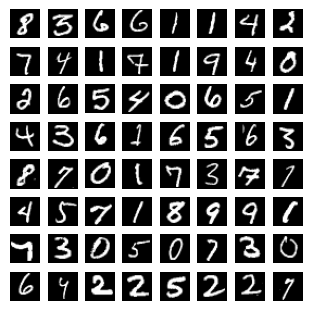

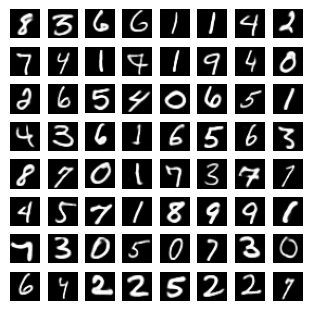

In [5]:
import matplotlib.pyplot as plt

eval_flag()

x = next(iter(dataloader_train))[0][:64, ...].to(device)
z_g_0 = sample_p_0(n=x.size(0))
z_g_k = sample_langevin_post_z(Variable(z_g_0), x*2-1, netG, netE)

fig = plt.figure(figsize=(3, 3), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
imgs = x.detach().cpu().reshape(8, 8, 28, 28).numpy()
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")
plt.show()

fig = plt.figure(figsize=(3, 3), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
imgs = netG(z_g_k).detach().cpu().reshape(8, 8, 28, 28).numpy()
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")
plt.show()

# Generation

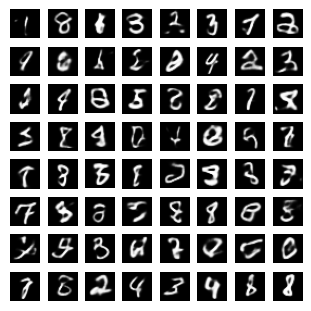

In [6]:
z_e_0 = sample_p_0(n=64)
z_e_ks = sample_langevin_prior_z(Variable(z_e_0), netE)

fig = plt.figure(figsize=(3, 3), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
imgs = netG(z_e_ks[-1]).detach().cpu().reshape(8, 8, 28, 28).numpy()
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")
plt.show()